# Project 3 - Recommender Systems

In [1]:
!pip install regex
!pip install nltk
!pip install sklearn
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
!pip install scikit-surprise

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import nltk
import multiprocessing
import umap.umap_ as umap
import umap.plot
import re
import string
import warnings

from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

np.random.seed(0)
random.seed(0)

zsh:1: no matches found: umap-learn[plot]


/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:66: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)


In [36]:
import os
current = os.getcwd()
Dataset_loc = current + '/Synthetic_Movie_Lens/'

In [37]:
data = pd.read_csv(Dataset_loc + "ratings.csv") 
data.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [4]:
data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501562,1.205946e+09
std,182.618491,35530.987199,1.042540,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
data = pd.read_csv(Dataset_loc + "movies.csv") 
data.head()

data['genres']
data['newgen'] = data['genres'].apply(lambda x: x.split('|'))
newlist = []
for values in data['newgen']:
    newlist += values
    
print(set(newlist))
print(len(set(newlist))) # 1 of it is 'no genres listed'.

{'Western', 'Musical', 'Comedy', 'Fantasy', 'Romance', 'Action', 'IMAX', 'Animation', 'Adventure', 'Horror', 'Children', 'Crime', 'Thriller', 'Drama', 'War', 'Mystery', 'Film-Noir', '(no genres listed)', 'Documentary', 'Sci-Fi'}
20


# Question 1A

In [6]:
Ratings_file = pd.read_csv(Dataset_loc + "ratings.csv",usecols=['userId','movieId','rating','timestamp']) 
user_ID = Ratings_file.pop('userId').values
movie_ID = Ratings_file.pop('movieId').values
Rating = Ratings_file.pop('rating').values
Sparsity = len(Rating)/(len(set(movie_ID))*len(set(user_ID)))
print('Sparsity:',Sparsity)

Sparsity: 0.016999683055613623


# Question 1B

Plot a histogram showing the frequency of the rating values: Bin the raw rating values
into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the
number of entries in the ratings matrix R that fall within each bin and use this count as the
height of the vertical axis for that particular bin. Comment on the shape of the histogram.

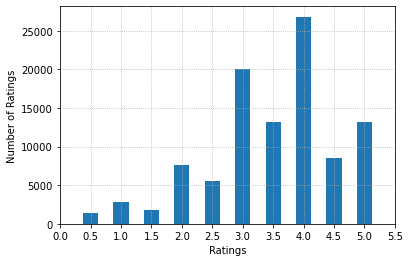

In [7]:
uni_values, uni_indices = np.unique(Rating, return_inverse=True)
plt.bar(uni_values, np.bincount(uni_indices), width=0.25)
locs, labels = plt.xticks()  
plt.grid(linestyle=':')
plt.xticks(np.arange(0,6,0.5),rotation=0)
plt.ylabel('Number of Ratings')
plt.xlabel('Ratings')
plt.savefig('Q2_1.png',dpi=500,bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Frequency of rating values')

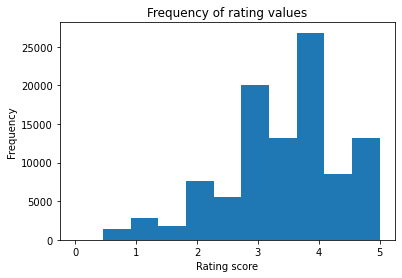

In [23]:
bins = np.linspace(0,5,num=12)
plt.hist(Rating,bins=bins)
plt.xlabel("Rating score")
plt.ylabel("Frequency")
plt.title("Frequency of rating values")

# Question 1C

Plot the distribution of the number of ratings received among movies: The X-axis
should be the movie index ordered by decreasing frequency and the Y -axis should be the number
of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend
is expected.

[329 317 307 ...   1   1   1]


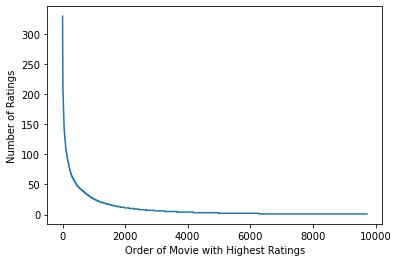

In [13]:
#Movie ID vs number of ratings
unique_movie,unique_counts=np.unique(movie_ID,return_counts=True)
count_sorts=np.argsort(unique_counts)
length=range(1,len(unique_movie)+1)
count=unique_counts[count_sorts[::-1]] #Decreasing Frequency
print(count)
plt.plot(length,count)
plt.xlabel('Order of Movie with Highest Ratings')
plt.ylabel('Number of Ratings')
plt.show()


# Question 1D

Plot the distribution of ratings among users: The X-axis should be the user index ordered
by decreasing frequency and the Y -axis should be the number of movies the user has rated.
The requirement of the plot is similar to that in Question C.


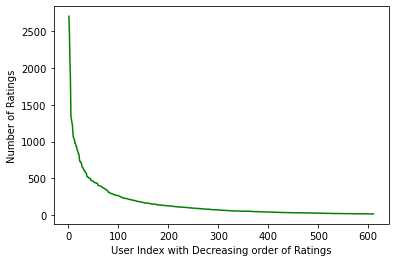

In [14]:
#User ID vs Number of movies the user has rated
unique_movie1,unique_counts1=np.unique(user_ID,return_counts=True)
count_sorts=np.argsort(unique_counts1)
length1=range(1,len(unique_movie1)+1)
count1=unique_counts1[count_sorts[::-1]] #Decreasing Frequency
#print(count1)
plt.plot(length1,count1,color='g')
plt.xlabel('User Index with Decreasing order of Ratings')
plt.ylabel('Number of Ratings')
plt.show()


# Question 1F

Compute the variance of the rating values received by each movie: Bin the variance
values into intervals of width 0.5 and use the binned variance values as the horizontal axis.
Count the number of movies with variance values in the binned intervals and use this count as
the vertical axis. Briefly comment on the shape of the resulting histogram

In [15]:
movie_set=set(movie_ID)
movie_set=list(movie_set) #can't subscript set
list_movies=[]
list_variance=[]
for movie_ele in range(len(movie_set)):
    #For each  unique movie ID, find all it's indexes from the movie ID corpus to access corresponding ratings
    pos=[ind for ind,ele in enumerate(movie_ID) if ele==movie_set[movie_ele] ]
    #list of all corresponding rattings values to find variance of a single unique movie ID's ratings
    variance=np.var(np.array(Rating[pos]))
    list_variance.append(variance)
    list_movies.append(movie_set[movie_ele])

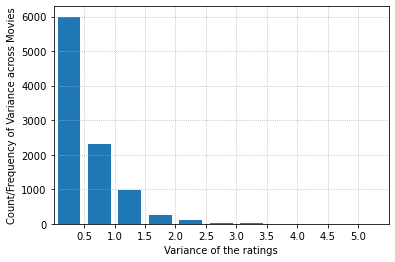

In [25]:
#Plotting histogram
plt.hist(list_variance, bins=np.arange(0,5.5,0.5),rwidth=0.75)
plt.xticks(np.arange(0.5,5.5,0.5))
plt.xlim([0, 5.5])
plt.grid(linestyle=':')
plt.xlabel('Variance of the ratings')
plt.ylabel('Count/Frequency of Variance across Movies')
plt.show()

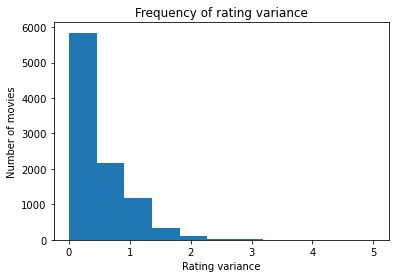

In [24]:
bins = np.linspace(0,5,num=12)
plt.figure()
plt.hist(list_variance, bins=bins)
plt.xlabel("Rating variance"); 
plt.ylabel("Number of movies"); 
plt.title("Frequency of rating variance")
plt.show()

# Question 2

Understanding the Pearson Correlation Coefficient:

In [19]:
print(max(Rating),min(Rating))

5.0 0.5


# Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the
original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of
neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average
MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis)
against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [25]:
#Get lineformat corresponding tags CSV file in dataset  - Documentation - https://surprise.readthedocs.io/en/stable/reader.html
CSV_reader = Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings = Dataset.load_from_file(Dataset_loc+'ratings.csv',reader=CSV_reader)

k = np.arange(2,102,2) 
list_RMSE = []
lisst_mae = []
for ele in k:
    knn = KNNWithMeans(k = ele, sim_options={'name': 'pearson'})
    final_res = cross_validate(knn, measures = ['rmse', 'mae'], data = Dataset_Ratings, cv = 10)
    list_RMSE.append(np.mean(final_res['test_rmse']))
    lisst_mae.append(np.mean(final_res['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

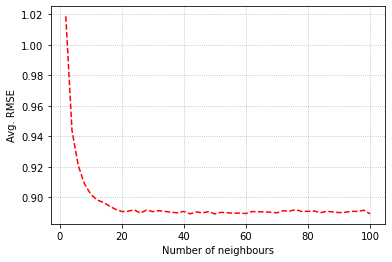

In [27]:
plt.plot(k,list_RMSE,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.savefig('Q4a.png',dpi=300,bbox_inches='tight')
plt.show()

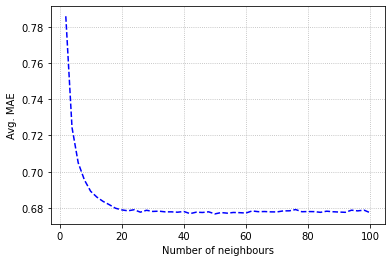

In [28]:
plt.plot(k,lisst_mae,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.ylabel('Avg. MAE')
plt.xlabel('Number of neighbours')
plt.savefig('Q4b.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 5

In [26]:
print('k: RMSE, MAE')
for i in range(len(k)):
    print(k[i], ': ', list_RMSE[i], ', ', lisst_mae[i])

k: RMSE, MAE
2 :  1.018768034893937 ,  0.7857753144380015
4 :  0.9437332859175933 ,  0.7243936934096996
6 :  0.9208146175391345 ,  0.7048910065122361
8 :  0.9088046464861635 ,  0.695423076266558
10 :  0.9020565993711454 ,  0.6891956585451109
12 :  0.8982478646987847 ,  0.6859768704291433
14 :  0.8966523189878487 ,  0.6836034279595953
16 :  0.8942047851489914 ,  0.6817947218490031
18 :  0.8920368254185703 ,  0.6798253236991231
20 :  0.8905586357817494 ,  0.6789263770375126
22 :  0.890734836055375 ,  0.6783961852018932
24 :  0.8917316108129663 ,  0.679008258489914
26 :  0.8895138688417512 ,  0.6776603592356266
28 :  0.8915744018820091 ,  0.6787001868761412
30 :  0.8905046598800069 ,  0.6780602196692277
32 :  0.8911121186404991 ,  0.6782140428119852
34 :  0.8906048947884508 ,  0.6778304537595741
36 :  0.890083461983162 ,  0.6778354867918295
38 :  0.889753737176713 ,  0.6776341817446483
40 :  0.8906640752960575 ,  0.6780348061274889
42 :  0.8890709525946228 ,  0.6768498897936197
44 :  0.89

# Question 6

In [15]:
def pop_trim(data, testset):
    ref = {}
    for j in data.raw_ratings:
        if j[1] in ref.keys():
            ref[j[1]].append(j[2])
        else:
            ref[j[1]] = []
            ref[j[1]].append(j[2])
            
    Pop_Trimmed_set = [j for j in testset if len(ref[j[1]]) > 2]
    return Pop_Trimmed_set
    
def unpop_trim(data, testset):
    ref = {}
    for j in data.raw_ratings:
        if j[1] in ref.keys():
            ref[j[1]].append(j[2])
        else:
            ref[j[1]] = []
            ref[j[1]].append(j[2])
            
    Unpop_trimmed_set = [j for j in testset if len(ref[j[1]]) <= 2]
    return Unpop_trimmed_set

def highvar_trim(data, testset):
    dict_of_items = {}
    for j in Dataset_Ratings.raw_ratings:
        if j[1] in dict_of_items.keys():
            dict_of_items[j[1]].append(j[2])
        else:
            dict_of_items[j[1]] = []
            dict_of_items[j[1]].append(j[2])
            
    High_Var_trimmed_set = [j for j in testset if (np.var(dict_of_items[j[1]]) >= 2 and len(dict_of_items[j[1]]) >= 5)]
    return High_Var_trimmed_set

In [86]:
from surprise import accuracy

k = np.arange(2,102,2) 

Popular_RMSE = []
k_Fold_valid =  KFold(n_splits=10)
for item in k:
    Local_RMSE = []
    print('Running for the iteration with K=',item)
    for trainset, testset in k_Fold_valid.split(Dataset_Ratings):
        Pop_Trimmed_set = pop_trim(Dataset_Ratings, testset)
        res = KNNWithMeans(k=item,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(Pop_Trimmed_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    Popular_RMSE.append(np.mean(Local_RMSE))

Running for the iteration with K= 2
Running for the iteration with K= 4
Running for the iteration with K= 6
Running for the iteration with K= 8
Running for the iteration with K= 10
Running for the iteration with K= 12
Running for the iteration with K= 14
Running for the iteration with K= 16
Running for the iteration with K= 18
Running for the iteration with K= 20
Running for the iteration with K= 22
Running for the iteration with K= 24
Running for the iteration with K= 26
Running for the iteration with K= 28
Running for the iteration with K= 30
Running for the iteration with K= 32
Running for the iteration with K= 34
Running for the iteration with K= 36
Running for the iteration with K= 38
Running for the iteration with K= 40
Running for the iteration with K= 42
Running for the iteration with K= 44
Running for the iteration with K= 46
Running for the iteration with K= 48
Running for the iteration with K= 50
Running for the iteration with K= 52
Running for the iteration with K= 54
Runni

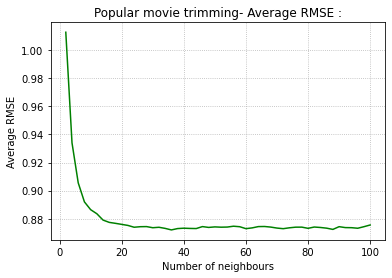

In [87]:
plt.plot(k,Popular_RMSE,color='g')
plt.grid(linestyle=':')
plt.title('Popular movie trimming- Average RMSE :')
plt.ylabel('Average RMSE')
plt.xlabel('Number of neighbours')
plt.savefig('Q6a.png',dpi=300,bbox_inches='tight')
plt.show()

In [88]:
print("RMSE- Popular movie trimming- Minimum avg. :", min(Popular_RMSE))
print("Value of K: %d" % k[[i for i, x in enumerate(Popular_RMSE) if x == min(Popular_RMSE)][0]])

RMSE- Popular movie trimming- Minimum avg. : 0.8719871055017627
Value of K: 36


All values are close. So we can use k = 20 as well.

In [89]:
UnPopular_RMSE = []
k_Fold_valid =  KFold(n_splits=10)

k = np.arange(2,102,2) 

for item in k:
    Local_RMSE = []
    print('Running for the iteration with K=',item)
    for trainset, testset in k_Fold_valid.split(Dataset_Ratings):
        Unpop_trimmed_set = unpop_trim(Dataset_Ratings, testset)
        Unpop_res = KNNWithMeans(k=item,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(Unpop_trimmed_set)
        Local_RMSE.append(accuracy.rmse(Unpop_res,verbose=False))
    UnPopular_RMSE.append(np.mean(Local_RMSE))

Running for the iteration with K= 2
Running for the iteration with K= 4
Running for the iteration with K= 6
Running for the iteration with K= 8
Running for the iteration with K= 10
Running for the iteration with K= 12
Running for the iteration with K= 14
Running for the iteration with K= 16
Running for the iteration with K= 18
Running for the iteration with K= 20
Running for the iteration with K= 22
Running for the iteration with K= 24
Running for the iteration with K= 26
Running for the iteration with K= 28
Running for the iteration with K= 30
Running for the iteration with K= 32
Running for the iteration with K= 34
Running for the iteration with K= 36
Running for the iteration with K= 38
Running for the iteration with K= 40
Running for the iteration with K= 42
Running for the iteration with K= 44
Running for the iteration with K= 46
Running for the iteration with K= 48
Running for the iteration with K= 50
Running for the iteration with K= 52
Running for the iteration with K= 54
Runni

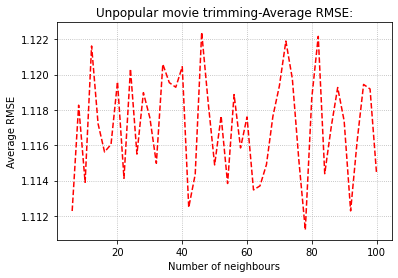

In [90]:
plt.plot(k[2:],UnPopular_RMSE[2:],linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Unpopular movie trimming-Average RMSE:')
plt.ylabel('Average RMSE')
plt.xlabel('Number of neighbours')
plt.savefig('Q13.png',dpi=300,bbox_inches='tight')
plt.show()

In [91]:
print("Unpopular movie trimming-Minimum average RMSE:", min(UnPopular_RMSE))
print("Value of K: %d" % k[[i for i, x in enumerate(UnPopular_RMSE) if x == min(UnPopular_RMSE)][0]])

Unpopular movie trimming-Minimum average RMSE: 1.1112045741730798
Value of K: 78


In [71]:
#High Variance Movie Trimming
High_Var_RMSE = []
k_Fold_valid =  KFold(n_splits=10)

for item in k:
    Local_RMSE = []
    print('Running for the iteration with K =',item)
    for trainset, testset in k_Fold_valid.split(Dataset_Ratings):
        High_Var_trimmed_set = highvar_trim(Dataset_Ratings, testset)
        Final_High_res = KNNWithMeans(k=item,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(High_Var_trimmed_set)
        Local_RMSE.append(accuracy.rmse(Final_High_res,verbose=False))
    High_Var_RMSE.append(np.mean(Local_RMSE))

Running for the iteration with K = 2
Running for the iteration with K = 4
Running for the iteration with K = 6
Running for the iteration with K = 8
Running for the iteration with K = 10
Running for the iteration with K = 12
Running for the iteration with K = 14
Running for the iteration with K = 16
Running for the iteration with K = 18
Running for the iteration with K = 20
Running for the iteration with K = 22
Running for the iteration with K = 24
Running for the iteration with K = 26
Running for the iteration with K = 28
Running for the iteration with K = 30
Running for the iteration with K = 32
Running for the iteration with K = 34
Running for the iteration with K = 36
Running for the iteration with K = 38
Running for the iteration with K = 40
Running for the iteration with K = 42
Running for the iteration with K = 44
Running for the iteration with K = 46
Running for the iteration with K = 48
Running for the iteration with K = 50
Running for the iteration with K = 52
Running for the 

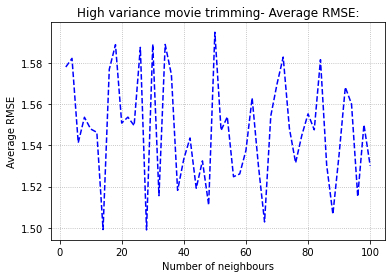

In [72]:
plt.plot(k,High_Var_RMSE,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('High variance movie trimming- Average RMSE:')
plt.ylabel('Average RMSE')
plt.xlabel('Number of neighbours')
plt.savefig('Q14.png',dpi=300,bbox_inches='tight')
plt.show()

In [73]:
print("High variance movie trimming- Minimum average RMSE:", min(High_Var_RMSE))
print("Value of K: %d" % k[[i for i, x in enumerate(High_Var_RMSE) if x == min(High_Var_RMSE)][0]])

High variance movie trimming- Minimum average RMSE: 1.499004534919353
Value of K: 28


In [ ]:
CSV_reader=Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings=Dataset.load_from_file(Dataset_loc+'ratings.csv',reader=CSV_reader)

k = 20
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
Thres_list = [2.5, 3.0, 3.5, 4.0]

res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(Test_list)

You should consider upgrading via the 'c:\users\veera\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


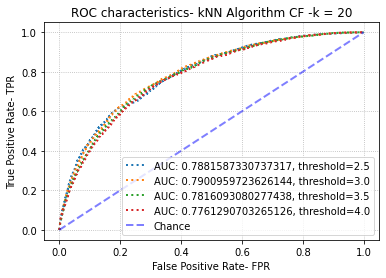

In [ ]:
fig, ax = plt.subplots()
for item in Thres_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(FPR, TPR,lw=2,linestyle=':',label="AUC: "+str(auc(FPR,TPR))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics- kNN Algorithm CF -k = 20')
plt.ylabel('True Positive Rate- TPR')
plt.xlabel('False Positive Rate- FPR')
plt.savefig('Q6.png',dpi=350,bbox_inches='tight')
plt.show() 

Popular

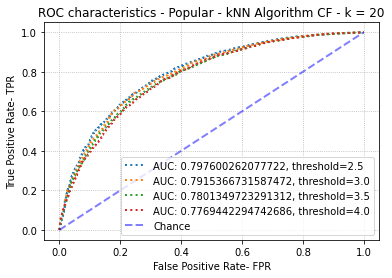

In [92]:
CSV_reader=Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings=Dataset.load_from_file(Dataset_loc+'ratings.csv',reader=CSV_reader)

k = 20
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
Thres_list = [2.5, 3.0, 3.5, 4.0]

Pop_Trimmed_set = pop_trim(Dataset_Ratings, Test_list)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(Pop_Trimmed_set)

fig, ax = plt.subplots()
for item in Thres_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(FPR, TPR,lw=2,linestyle=':',label="AUC: "+str(auc(FPR,TPR))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics - Popular - kNN Algorithm CF - k = 20')
plt.ylabel('True Positive Rate- TPR')
plt.xlabel('False Positive Rate- FPR')
plt.savefig('Q6a.png',dpi=350,bbox_inches='tight')
plt.show() 

Unpopular

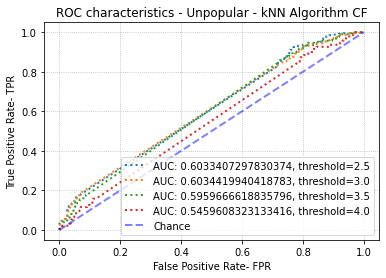

In [99]:
CSV_reader=Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings=Dataset.load_from_file(Dataset_loc+'ratings.csv',reader=CSV_reader)

k = 20
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
Thres_list = [2.5, 3.0, 3.5, 4.0]

Unpop_trimmed_set = unpop_trim(Dataset_Ratings, Test_list)

res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(Unpop_trimmed_set)

fig, ax = plt.subplots()
for item in Thres_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(FPR, TPR,lw=2,linestyle=':',label="AUC: "+str(auc(FPR,TPR))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics - Unpopular - kNN Algorithm CF')
plt.ylabel('True Positive Rate- TPR')
plt.xlabel('False Positive Rate- FPR')
plt.savefig('Q6b.png',dpi=350,bbox_inches='tight')
plt.show() 

High Variance

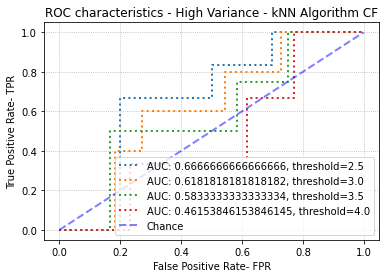

In [101]:
CSV_reader=Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings=Dataset.load_from_file(Dataset_loc+'ratings.csv',reader=CSV_reader)

k = 20
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
Thres_list = [2.5, 3.0, 3.5, 4.0]

High_Var_trimmed_set = highvar_trim(Dataset_Ratings, Test_list)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(High_Var_trimmed_set)

fig, ax = plt.subplots()
for item in Thres_list:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR, TPR, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(FPR, TPR,lw=2,linestyle=':',label="AUC: "+str(auc(FPR,TPR))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics - High Variance - kNN Algorithm CF')
plt.ylabel('True Positive Rate- TPR')
plt.xlabel('False Positive Rate- FPR')
plt.savefig('Q6c.png',dpi=350,bbox_inches='tight')
plt.show() 

# Question 8A

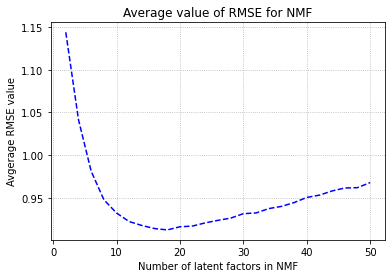

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

List_K = np.arange(2,52,2)
RMSE_NMF_List = []
MAE_NMF_List = []
for K_value in List_K:
    res = cross_validate(NMF(n_factors=K_value,n_epochs=50,verbose=False),
                         measures=['rmse','mae'],data = Dataset_Ratings,cv=10,n_jobs=-1)   
    RMSE_NMF_List.append(np.mean(res['test_rmse']))
    MAE_NMF_List.append(np.mean(res['test_mae']))

plt.plot(List_K,RMSE_NMF_List,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Average value of RMSE for NMF')
plt.ylabel('Avgerage RMSE value')
plt.xlabel('Number of latent factors in NMF')
plt.savefig('Q8a.png',dpi=350,bbox_inches='tight')
plt.show()

plt.plot(List_K,RMSE_NMF_List,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Average value of RMSE for NMF')
plt.ylabel('Avgerage RMSE value')
plt.xlabel('Number of latent factors in NMF')
plt.savefig('Q8a.png',dpi=350,bbox_inches='tight')
plt.show()

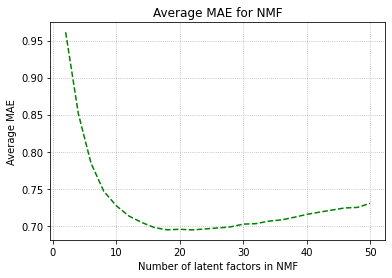

In [ ]:
plt.plot(List_K,MAE_NMF_List,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Average MAE for NMF')
plt.ylabel('Average MAE')
plt.xlabel('Number of latent factors in NMF')
plt.savefig('Q8b.png',dpi=350,bbox_inches='tight')
plt.show()

# Question 8B

In [ ]:
print("Minimum Average value of RMSE (NMF): %f, value of K: %d" % (min(RMSE_NMF_List),List_K[[i for i, x in enumerate(RMSE_NMF_List) if x == min(RMSE_NMF_List)][0]]))
print("Minimum Average value of MAE (NMF): %f, value of K: %d" % (min(MAE_NMF_List),List_K[[i for i, x in enumerate(MAE_NMF_List) if x == min(MAE_NMF_List)][0]]))

Minimum Average value of RMSE (NMF): 0.912530, value of K: 18
Minimum Average value of MAE (NMF): 0.694350, value of K: 22


# Question 8C

Iterating for the K value = 2
Iterating for the K value = 4
Iterating for the K value = 6
Iterating for the K value = 8
Iterating for the K value = 10
Iterating for the K value = 12
Iterating for the K value = 14
Iterating for the K value = 16
Iterating for the K value = 18
Iterating for the K value = 20
Iterating for the K value = 22
Iterating for the K value = 24
Iterating for the K value = 26
Iterating for the K value = 28
Iterating for the K value = 30
Iterating for the K value = 32
Iterating for the K value = 34
Iterating for the K value = 36
Iterating for the K value = 38
Iterating for the K value = 40
Iterating for the K value = 42
Iterating for the K value = 44
Iterating for the K value = 46
Iterating for the K value = 48
Iterating for the K value = 50


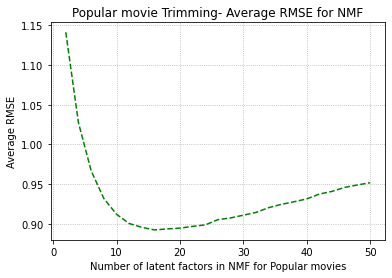

In [97]:
Pop_RMSE_NMF_list = []
K_Fold =  KFold(n_splits=10)

for K_value in List_K:
    Local_RMSE = []
    print('Iterating for the K value =',K_value)
    for Train_list, Test_list in K_Fold.split(Dataset_Ratings):
        trimmed_set = pop_trim(Dataset_Ratings, Test_list)
        res = NMF(n_factors=K_value,n_epochs=50,verbose=False).fit(Train_list).test(trimmed_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    Pop_RMSE_NMF_list.append(np.mean(Local_RMSE))
plt.plot(List_K,Pop_RMSE_NMF_list,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Popular movie Trimming- Average RMSE for NMF')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors in NMF for Popular movies')
plt.savefig('Q8c.png',dpi=350,bbox_inches='tight')
plt.show()

In [102]:
print("Minimum avg. RMSE (NMF, Popular movie trimming):", min(Pop_RMSE_NMF_list))


Minimum avg. RMSE (NMF, Popular movie trimming): 0.8925320415716778


In [103]:
UnPop_RMSE_NMF = []
k_Fold =  KFold(n_splits=10)
for K_Value in List_K:
    Local_RMSE = []
    print('Iteration for the value of K =',K_Value)
    for Train_list, Test_list in k_Fold.split(Dataset_Ratings):
        trimmed_set = unpop_trim(Dataset_Ratings, Test_list)
        res = NMF(n_factors=K_Value,n_epochs=50,verbose=False).fit(Train_list).test(trimmed_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    UnPop_RMSE_NMF.append(np.mean(Local_RMSE))

Iteration for the value of K = 2
Iteration for the value of K = 4
Iteration for the value of K = 6
Iteration for the value of K = 8
Iteration for the value of K = 10
Iteration for the value of K = 12
Iteration for the value of K = 14
Iteration for the value of K = 16
Iteration for the value of K = 18
Iteration for the value of K = 20
Iteration for the value of K = 22
Iteration for the value of K = 24
Iteration for the value of K = 26
Iteration for the value of K = 28
Iteration for the value of K = 30
Iteration for the value of K = 32
Iteration for the value of K = 34
Iteration for the value of K = 36
Iteration for the value of K = 38
Iteration for the value of K = 40
Iteration for the value of K = 42
Iteration for the value of K = 44
Iteration for the value of K = 46
Iteration for the value of K = 48
Iteration for the value of K = 50


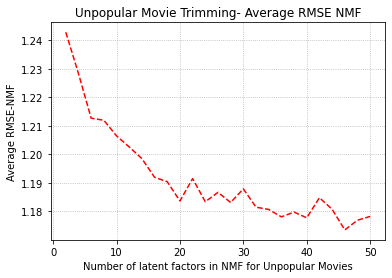

In [104]:
plt.plot(List_K,UnPop_RMSE_NMF,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Unpopular Movie Trimming- Average RMSE NMF')
plt.ylabel('Average RMSE-NMF')
plt.xlabel('Number of latent factors in NMF for Unpopular Movies')
plt.savefig('Q8c2.png',dpi=350,bbox_inches='tight')
plt.show()

In [105]:
print(" Unpopular movie Trimming- Minimum average RMSE -NMF", min(UnPop_RMSE_NMF))


 Unpopular movie Trimming- Minimum average RMSE -NMF 1.173498893400049


In [16]:
Var_RMSE_NMF = []
k_Fold =  KFold(n_splits=10)

List_K = np.arange(2,52,2)
CSV_reader=Reader(rating_scale=(0.5, 5),skip_lines=1,sep=',', line_format='user item rating timestamp')
Dataset_Ratings=Dataset.load_from_file(Dataset_loc+'ratings.csv',reader=CSV_reader)
for K_value in List_K:
    Local_RMSE = []
    print('Iteration for the value of K =',K_value)
    for Train_list, Test_list in k_Fold.split(Dataset_Ratings):
        trimmed_set = highvar_trim(Dataset_Ratings, Test_list)
        res = NMF(n_factors=K_value,n_epochs=50,verbose=False).fit(Train_list).test(trimmed_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    Var_RMSE_NMF.append(np.mean(Local_RMSE))

Iteration for the value of K = 2
Iteration for the value of K = 4
Iteration for the value of K = 6
Iteration for the value of K = 8
Iteration for the value of K = 10
Iteration for the value of K = 12
Iteration for the value of K = 14
Iteration for the value of K = 16
Iteration for the value of K = 18
Iteration for the value of K = 20
Iteration for the value of K = 22
Iteration for the value of K = 24
Iteration for the value of K = 26
Iteration for the value of K = 28
Iteration for the value of K = 30
Iteration for the value of K = 32
Iteration for the value of K = 34
Iteration for the value of K = 36
Iteration for the value of K = 38
Iteration for the value of K = 40
Iteration for the value of K = 42
Iteration for the value of K = 44
Iteration for the value of K = 46
Iteration for the value of K = 48
Iteration for the value of K = 50


In [17]:
print("High Variance movie Trimming- Minimum average RMSE -NMF", min(Var_RMSE_NMF))

High Variance movie Trimming- Minimum average RMSE -NMF 1.6182565408745588


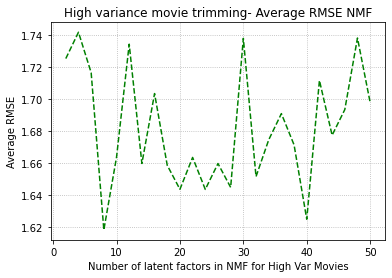

In [18]:
plt.plot(List_K,Var_RMSE_NMF,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('High variance movie trimming- Average RMSE NMF')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors in NMF for High Var Movies')
plt.savefig('Q8c3.png',dpi=350,bbox_inches='tight')
plt.show()

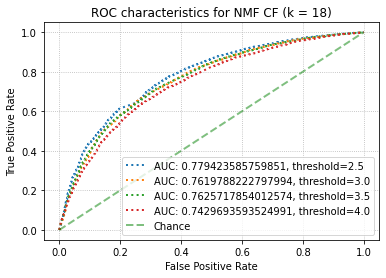

In [ ]:
k = List_K[[i for i, x in enumerate(RMSE_NMF_List) if x == min(RMSE_NMF_List)][0]]
Thresh_List = [2.5, 3.0, 3.5, 4.0]
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
res  = NMF(n_factors=k,n_epochs=50,verbose=False).fit(Train_list).test(Test_list)

fig, ax = plt.subplots()
for item in Thresh_List:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF (k = 18)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Q8d.png',dpi=350,bbox_inches='tight')
plt.show() 


# Question 9

In [ ]:
genre = pd.read_csv(Dataset_loc+'movies.csv',usecols=['movieId','title','genres'])
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
NMF_K20 = NMF(n_factors=20,n_epochs=50,verbose=False)
NMF_K20.fit(Train_list).test(Test_list)
U_mat = NMF_K20.pu
V_mat = NMF_K20.qi

In [24]:
cols = [1,3,5,7,11,15,19]
for item in cols:
    print('Column number correspoding to V Matrix Instance: ',item)
    selected_col = V_mat[:,item]
    sorted_col = np.argsort(selected_col)[::-1]
    newlist = []
    for i in sorted_col[0:10]:
        print(genre['genres'][i])
        lst = genre['genres'][i].split('|')
        newlist += lst
    
    print('Genres: ', set(newlist))
    print('Number of Unique Genres:', len(set(newlist)))

    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

Column number correspoding to V Matrix Instance:  1
Adventure
Horror|Mystery|Thriller
Children|Comedy
Documentary
Crime|Drama|Mystery|Thriller
Drama
Action|Adventure|Sci-Fi|IMAX
Comedy
Drama|Western
Comedy|Sci-Fi
Genres:  {'Documentary', 'Sci-Fi', 'Adventure', 'Comedy', 'Crime', 'Action', 'Children', 'Drama', 'Thriller', 'Horror', 'Western', 'Mystery', 'IMAX'}
Number of Unique Genres: 13
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Column number correspoding to V Matrix Instance:  3
Action|Children|Sci-Fi|IMAX
Action|Drama|Sci-Fi
Horror
Action|Drama|War
Children
Drama
Horror|Mystery|Thriller
Comedy
Mystery|Thriller
Comedy|Drama
Genres:  {'Sci-Fi', 'Comedy', 'War', 'Action', 'Children', 'Drama', 'Thriller', 'Horror', 'Mystery', 'IMAX'}
Number of Unique Genres: 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Column number correspoding to V Matrix Instance:  5
Drama|Horror
Action|Crime|Drama
Comedy|Crime
Adventure|Drama|Romance
Adventure|Drama|Thriller
Action|Comedy
Co

# Question 10A

In [ ]:
#MF Collaborative Filter
#Treat MF with bias/regularization as SVD kind of optimization problem 

List_K = np.arange(2,52,2)
RMSE_MF_SVD = []
MAE_MF_SVD = []
for item in List_K:
    res = cross_validate(SVD(n_factors=item, n_epochs=30,verbose=False),
                         measures=['rmse','mae'],data = Dataset_Ratings, cv=10, n_jobs=-1)   
    RMSE_MF_SVD.append(np.mean(res['test_rmse']))
    MAE_MF_SVD.append(np.mean(res['test_mae']))

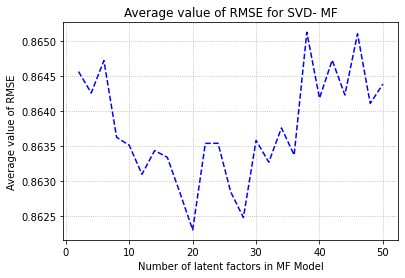

Minimum average value of RMSE for SVD: 0.862305, K Value: 20


In [54]:
plt.plot(List_K,RMSE_MF_SVD,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Average value of RMSE for SVD- MF')
plt.ylabel('Average value of RMSE')
plt.xlabel('Number of latent factors in MF Model')
plt.savefig('Q10a.png',dpi=350,bbox_inches='tight')
plt.show()

print("Minimum average value of RMSE for SVD: %f, K Value: %d" % (min(RMSE_MF_SVD),List_K[[i for i, x in enumerate(RMSE_MF_SVD) if x == min(RMSE_MF_SVD)][0]]))

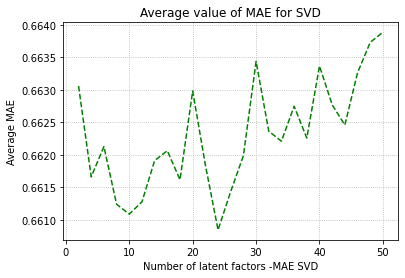

In [48]:
plt.plot(List_K,MAE_MF_SVD,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Average value of MAE for SVD')
plt.ylabel('Average MAE')
plt.xlabel('Number of latent factors -MAE SVD')
plt.savefig('Q10a2.png',dpi=350,bbox_inches='tight')
plt.show()

# Question 10B

In [50]:
print("Minimum average value of MAE for SVD: %f, K Value: %d" % (min(MAE_MF_SVD),List_K[[i for i, x in enumerate(MAE_MF_SVD) if x == min(MAE_MF_SVD)][0]]))

Minimum average value of MAE for SVD: 0.660847, K Value: 24


# Question 10C

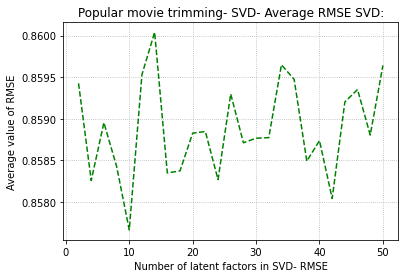

In [106]:
Popular_RMSE_SVD = []
k_fold =  KFold(n_splits=10)
for item in List_K:
    Local_RMSE = []
    for Train_list, Test_list in k_fold.split(Dataset_Ratings):
        trimmed_set = pop_trim(Dataset_Ratings, Test_list)
        res = SVD(n_factors=item,n_epochs=20,verbose=False).fit(Train_list).test(trimmed_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    Popular_RMSE_SVD.append(np.mean(Local_RMSE))

plt.plot(List_K,Popular_RMSE_SVD,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Popular movie trimming- SVD- Average RMSE SVD:')
plt.ylabel('Average value of RMSE')
plt.xlabel('Number of latent factors in SVD- RMSE')
plt.savefig('Q10c.png',dpi=300,bbox_inches='tight')
plt.show()

In [107]:
print("Popular movie trimming- Minimum average value of RMSE- SVD", min(Popular_RMSE_SVD))

Popular movie trimming- Minimum average value of RMSE- SVD 0.8576636998948253


In [108]:
Unpop_RMSE_SVD = []
k_fold =  KFold(n_splits=10)
for item in List_K:
    Local_RMSE = []
    print('Iteration for the value of K =',item)
    for Train_list, Test_list in k_fold.split(Dataset_Ratings):
        trimmed_set = unpop_trim(Dataset_Ratings, Test_list)
        res = SVD(n_factors=item,n_epochs=20,verbose=False).fit(Train_list).test(trimmed_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    Unpop_RMSE_SVD.append(np.mean(Local_RMSE))


Iteration for the value of K = 2
Iteration for the value of K = 4
Iteration for the value of K = 6
Iteration for the value of K = 8
Iteration for the value of K = 10
Iteration for the value of K = 12
Iteration for the value of K = 14
Iteration for the value of K = 16
Iteration for the value of K = 18
Iteration for the value of K = 20
Iteration for the value of K = 22
Iteration for the value of K = 24
Iteration for the value of K = 26
Iteration for the value of K = 28
Iteration for the value of K = 30
Iteration for the value of K = 32
Iteration for the value of K = 34
Iteration for the value of K = 36
Iteration for the value of K = 38
Iteration for the value of K = 40
Iteration for the value of K = 42
Iteration for the value of K = 44
Iteration for the value of K = 46
Iteration for the value of K = 48
Iteration for the value of K = 50


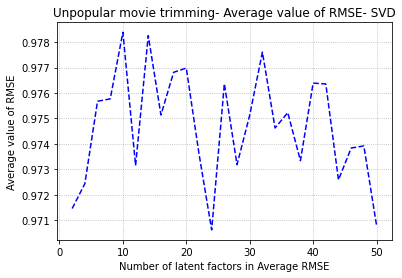

In [109]:
plt.plot(List_K,Unpop_RMSE_SVD,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Unpopular movie trimming- Average value of RMSE- SVD')
plt.ylabel('Average value of RMSE')
plt.xlabel('Number of latent factors in Average RMSE')
plt.savefig('Q10c2.png',dpi=350,bbox_inches='tight')
plt.show()

In [110]:
print("Unpopular movie trimming- Minimum average value of RMSE -SVD):", min(Unpop_RMSE_SVD))

Unpopular movie trimming- Minimum average value of RMSE -SVD): 0.9706183651935959


In [ ]:
High_Var_RMSE_SVD = []
k_fold =  KFold(n_splits=10)

for item in List_K:
    Local_RMSE = []
    print('Iteration for the value of K =',item)
    for Train_list, Test_list in k_fold.split(Dataset_Ratings):
        Var_trim_set = highvar_trim(Dataset_Ratings, Test_list)
        res = SVD(n_factors=item,n_epochs=20,verbose=False).fit(Train_list).test(Var_trim_set)
        Local_RMSE.append(accuracy.rmse(res,verbose=False))
    High_Var_RMSE_SVD.append(np.mean(Local_RMSE))

Iteration for the value of K = 2
Iteration for the value of K = 4
Iteration for the value of K = 6
Iteration for the value of K = 8
Iteration for the value of K = 10
Iteration for the value of K = 12
Iteration for the value of K = 14
Iteration for the value of K = 16
Iteration for the value of K = 18
Iteration for the value of K = 20
Iteration for the value of K = 22
Iteration for the value of K = 24
Iteration for the value of K = 26
Iteration for the value of K = 28
Iteration for the value of K = 30
Iteration for the value of K = 32
Iteration for the value of K = 34
Iteration for the value of K = 36
Iteration for the value of K = 38
Iteration for the value of K = 40
Iteration for the value of K = 42
Iteration for the value of K = 44
Iteration for the value of K = 46
Iteration for the value of K = 48
Iteration for the value of K = 50


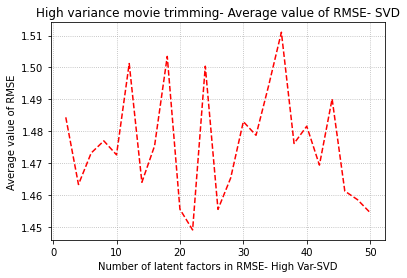

In [ ]:
plt.plot(List_K,High_Var_RMSE_SVD,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('High variance movie trimming- Average value of RMSE- SVD')
plt.ylabel('Average value of RMSE')
plt.xlabel('Number of latent factors in RMSE- High Var-SVD')
plt.savefig('Q10c3.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
print("High variance movie trimming- Minimum average value of RMSE- SVD", min(High_Var_RMSE_SVD))


High variance movie trimming- Minimum average value of RMSE- SVD 1.4489840651169374


In [ ]:
# Use K's value found in Question b to find ROC curves and associated areas

K_Value = List_K[[i for i, x in enumerate(RMSE_MF_SVD) if x == min(RMSE_MF_SVD)][0]]
thres = [2.5, 3.0, 3.5, 4.0]
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
res  = SVD(n_factors=K_Value,n_epochs=20,verbose=False).fit(Train_list).test(Test_list)

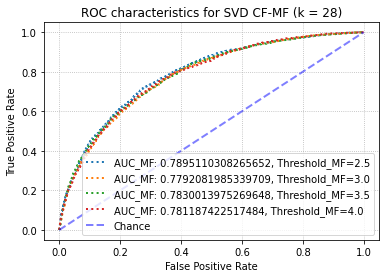

In [ ]:
fig, ax = plt.subplots()
for thres_val in thres:
    thresholded_out = []
    for row in res:
        if row.r_ui > thres_val:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    FPR_MF, TPR_MF, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(FPR_MF, TPR_MF,lw=2,linestyle=':',label="AUC_MF: "+str(auc(FPR_MF,TPR_MF))+', Threshold_MF='+str(thres_val))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for SVD CF-MF (k = '+ str(K_Value)+')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Q10d.png',dpi=350,bbox_inches='tight')
plt.show()

# Question 11

In [112]:
Set_User_ID = list(set(user_ID))
Mean_user_Ratings = []
for User_idx in Set_User_ID:
    idx = np.where(user_ID == User_idx)
    Mean_user_Ratings.append(np.mean(Rating[idx]))

In [ ]:
k_fold = KFold(n_splits=10)
Local_RMSE = []
for Train_list, Test_list in k_fold.split(Dataset_Ratings):
    res = [Mean_user_Ratings[int(row[0])-1] for row in Test_list]
    gt = [row[2] for row in Test_list]
    Local_RMSE.append(mean_squared_error(gt,res,squared=False))
Naive_CF_RMSE = np.mean(Local_RMSE)
print('Average RMSE value for Naive Collaborative Filtering: ',Naive_CF_RMSE)

Average RMSE value for Naive Collaborative Filtering:  0.934689278702231


In [113]:
Popular_Naive_CF_Local_RMSE = []
k_fold =  KFold(n_splits=10)
for Train_list, Test_list in k_fold.split(Dataset_Ratings):
    trimmed_set = pop_trim(Dataset_Ratings, Test_list)
    res = [Mean_user_Ratings[int(row[0])-1] for row in trimmed_set]
    gt = [row[2] for row in trimmed_set]
    Popular_Naive_CF_Local_RMSE.append(mean_squared_error(gt,res,squared=False))
Pop_Naive_CF_RMSE = np.mean(Popular_Naive_CF_Local_RMSE)
print('Popular movie trimming- Average RMSE value for Naive Filtering: ',Pop_Naive_CF_RMSE)


Popular movie trimming- Average RMSE value for Naive Filtering:  0.9323153270544065


In [114]:
UnPopular_Naive_CF_Local_RMSE = []
k_fold =  KFold(n_splits=10)
for Train_list, Test_list in k_fold.split(Dataset_Ratings):
    trimmed_set = unpop_trim(Dataset_Ratings, Test_list)
    res = [Mean_user_Ratings[int(row[0])-1] for row in trimmed_set]
    gt = [row[2] for row in trimmed_set]
    UnPopular_Naive_CF_Local_RMSE.append(mean_squared_error(gt,res,squared=False))
UnPop_Naive_CF_RMSE = np.mean(UnPopular_Naive_CF_Local_RMSE)
print('Unpopular movie trimming- Average RMSE value for Naive Filtering: ',UnPop_Naive_CF_RMSE)


Unpopular movie trimming- Average RMSE value for Naive Filtering:  0.971072554000641


In [ ]:
High_Var_Naive_CF_Local_RMSE = []
k_fold =  KFold(n_splits=10)

for Train_list, Test_list in k_fold.split(Dataset_Ratings):
    trimmed_set = highvar_trim(Dataset_Ratings, Test_list)
    res = [Mean_user_Ratings[int(row[0])-1] for row in trimmed_set]
    gt = [row[2] for row in trimmed_set]
    High_Var_Naive_CF_Local_RMSE.append(mean_squared_error(gt,res,squared=False))
High_Var_Naive_CF_RMSE = np.mean(High_Var_Naive_CF_Local_RMSE)
print('High Variance movie trimming- Average RMSE value for Naive Filtering: ',High_Var_Naive_CF_RMSE)


High Variance movie trimming- Average RMSE value for Naive Filtering:  1.481603271265438


# Question 12

In [ ]:
Train_list, Test_list = train_test_split(Dataset_Ratings, test_size=0.1)
SVD_Result  = SVD(n_factors=20,n_epochs=20,verbose=False).fit(Train_list).test(Test_list)
NMF_Result  = NMF(n_factors=18,n_epochs=50,verbose=False).fit(Train_list).test(Test_list)
KNNMeans_Result = KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(Test_list)

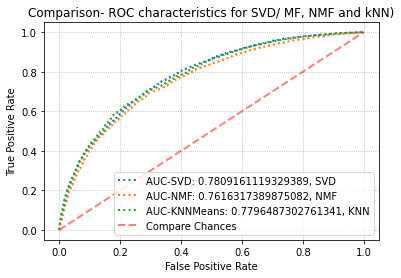

In [ ]:
fig, ax = plt.subplots()
Thresholded_Result = []
for row in SVD_Result:
    if row.r_ui > 3:
        Thresholded_Result.append(1)
    else:
        Thresholded_Result.append(0)
FPR_SVD, TPR_SVD, thresholds = roc_curve(Thresholded_Result, [row.est for row in SVD_Result])
ax.plot(FPR_SVD, TPR_SVD,lw=2,linestyle=':',label="AUC-SVD: "+str(auc(FPR_SVD,TPR_SVD))+', SVD')  

Thresholded_Result = []
for row in NMF_Result:
    if row.r_ui > 3:
        Thresholded_Result.append(1)
    else:
        Thresholded_Result.append(0)
FPR_NMF, TPR_NMF, thresholds = roc_curve(Thresholded_Result, [row.est for row in NMF_Result])
ax.plot(FPR_NMF, TPR_NMF,lw=2,linestyle=':',label="AUC-NMF: "+str(auc(FPR_NMF,TPR_NMF))+', NMF')  

Thresholded_Result = []
for row in KNNMeans_Result:
    if row.r_ui > 3:
        Thresholded_Result.append(1)
    else:
        Thresholded_Result.append(0)
FPR_KNNMeans, TPR_KNNMeans, thresholds = roc_curve(Thresholded_Result, [row.est for row in KNNMeans_Result])
ax.plot(FPR_KNNMeans, TPR_KNNMeans,lw=2,linestyle=':',label="AUC-KNNMeans: "+str(auc(FPR_KNNMeans,TPR_KNNMeans))+', KNN')  

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Compare Chances', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('Comparison- ROC characteristics for SVD/ MF, NMF and kNN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Q12.png',dpi=350,bbox_inches='tight')
plt.show()

# Question 14

In [ ]:
#Precision Recall Metrics for Different Models
# K here are the t values not 'k', which is set to 20.
K = np.arange(1,26,1)
k_fold = KFold(n_splits=10)

prec_list_KNN = []
rec_list_KNN = []
for val in K:
    print('Iterating  for the value of K =',val)
    precision_local_set = []
    recall__local_set = []
    for Train_list, Test_list in k_fold.split(Dataset_Ratings):
        D = {} #dictionary of movies liked by users
        for row in Test_list:
            if row[0] in D.keys():
                if row[2] >= 3.0:
                    D[row[0]].add(row[1])
            else:
                D[row[0]] = set()
                if row[2] >= 3.0:
                    D[row[0]].add(row[1])    
        dict_of_items = {} #dictionary of all movies rated by users
        for row in Test_list:
            if row[0] in dict_of_items.keys():
                dict_of_items[row[0]].append(row[1])
            else:
                dict_of_items[row[0]] = []
                dict_of_items[row[0]].append(row[1])
        KNN_Mod_Testlist = [row for row in Test_list if (len(dict_of_items[row[0]]) >= val and len(D[row[0]]) > 0)]
        res = KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(Train_list).test(KNN_Mod_Testlist)
        Est_Ratings = {} #dictionary of estimated ratings by users
        for row in res:
            if row[0] in Est_Ratings.keys():
                Est_Ratings[row[0]].append((row[1],row[3]))
            else:
                Est_Ratings[row[0]] = []
                Est_Ratings[row[0]].append((row[1],row[3]))
        precision_u = []
        recall_u = []
        for item in Est_Ratings.keys():
            Set_all = Est_Ratings[item]
            Set_all = sorted(Set_all,key=lambda x:x[1],reverse=True)
            Set_K = set([row[0] for row in Set_all[0:val]])
            precision_u.append(len(Set_K.intersection(D[item]))/float(len(Set_K)))
            recall_u.append(len(Set_K.intersection(D[item]))/float(len(D[item])))
        precision_local_set.append(np.mean(precision_u))
        recall__local_set.append(np.mean(recall_u))
    prec_list_KNN.append(np.mean(precision_local_set))
    rec_list_KNN.append(np.mean(recall__local_set))

Iterating  for the value of K = 1
Iterating  for the value of K = 2
Iterating  for the value of K = 3
Iterating  for the value of K = 4
Iterating  for the value of K = 5
Iterating  for the value of K = 6
Iterating  for the value of K = 7
Iterating  for the value of K = 8
Iterating  for the value of K = 9
Iterating  for the value of K = 10
Iterating  for the value of K = 11
Iterating  for the value of K = 12
Iterating  for the value of K = 13
Iterating  for the value of K = 14
Iterating  for the value of K = 15
Iterating  for the value of K = 16
Iterating  for the value of K = 17
Iterating  for the value of K = 18
Iterating  for the value of K = 19
Iterating  for the value of K = 20
Iterating  for the value of K = 21
Iterating  for the value of K = 22
Iterating  for the value of K = 23
Iterating  for the value of K = 24
Iterating  for the value of K = 25


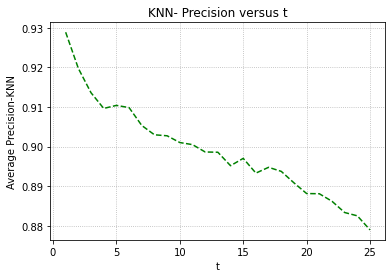

In [ ]:
plt.plot(K,prec_list_KNN,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('KNN- Precision versus t')
plt.ylabel('Average Precision-KNN')
plt.xlabel('t')
plt.savefig('Q14a1.png',dpi=350,bbox_inches='tight')
plt.show()

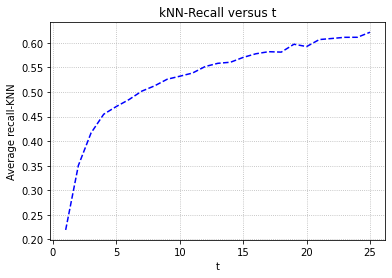

In [ ]:
plt.plot(K,rec_list_KNN,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('kNN-Recall versus t')
plt.ylabel('Average recall-KNN')
plt.xlabel('t')
plt.savefig('Q14a2.png',dpi=350,bbox_inches='tight')
plt.show()

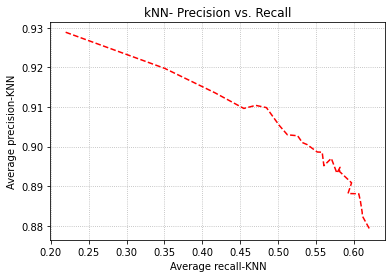

In [ ]:
plt.plot(rec_list_KNN,prec_list_KNN,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('kNN- Precision vs. Recall')
plt.ylabel('Average precision-KNN')
plt.xlabel('Average recall-KNN')
plt.savefig('Q14a3.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
t = np.arange(1,26,1)
k_fold = KFold(n_splits=10)

prec_list_NMF = []
rec_list_NMF = []
for val in t:
    print('Iterating for the value of t =',val)
    precision_Local_set = []
    recall_Local_set = []
    for Train_list, Test_list in k_fold.split(Dataset_Ratings):
        G = {} 
        for row in Test_list:
            if row[0] in G.keys():
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])
            else:
                G[row[0]] = set()
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])    
        dict_of_items = {} 
        for row in Test_list:
            if row[0] in dict_of_items.keys():
                dict_of_items[row[0]].append(row[1])
            else:
                dict_of_items[row[0]] = []
                dict_of_items[row[0]].append(row[1])
        NMF_mod_testset = [row for row in Test_list if (len(dict_of_items[row[0]]) >= val and len(G[row[0]]) > 0)]
        res = NMF(n_factors=18,n_epochs=50,verbose=False).fit(Train_list).test(NMF_mod_testset)
        Est_Ratings = {} 
        for row in res:
            if row[0] in Est_Ratings.keys():
                Est_Ratings[row[0]].append((row[1],row[3]))
            else:
                Est_Ratings[row[0]] = []
                Est_Ratings[row[0]].append((row[1],row[3]))
        precision_u = []
        recall_u = []
        for item in Est_Ratings.keys():
            Set_all = Est_Ratings[item]
            Set_all = sorted(Set_all,key=lambda x:x[1],reverse=True)
            Set_t = set([row[0] for row in Set_all[0:val]])
            precision_u.append(len(Set_t.intersection(G[item]))/float(len(Set_t)))
            recall_u.append(len(Set_t.intersection(G[item]))/float(len(G[item])))
        precision_Local_set.append(np.mean(precision_u))
        recall_Local_set.append(np.mean(recall_u))
    prec_list_NMF.append(np.mean(precision_Local_set))
    rec_list_NMF.append(np.mean(recall_Local_set))

Iterating for the value of t = 1
Iterating for the value of t = 2
Iterating for the value of t = 3
Iterating for the value of t = 4
Iterating for the value of t = 5
Iterating for the value of t = 6
Iterating for the value of t = 7
Iterating for the value of t = 8
Iterating for the value of t = 9
Iterating for the value of t = 10
Iterating for the value of t = 11
Iterating for the value of t = 12
Iterating for the value of t = 13
Iterating for the value of t = 14
Iterating for the value of t = 15
Iterating for the value of t = 16
Iterating for the value of t = 17
Iterating for the value of t = 18
Iterating for the value of t = 19
Iterating for the value of t = 20
Iterating for the value of t = 21
Iterating for the value of t = 22
Iterating for the value of t = 23
Iterating for the value of t = 24
Iterating for the value of t = 25


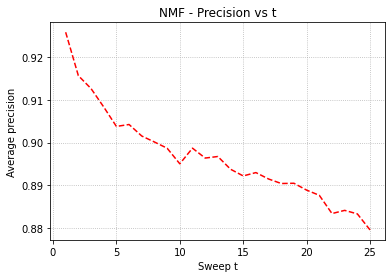

In [ ]:
plt.plot(t,prec_list_NMF,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('NMF - Precision vs t')
plt.ylabel('Average precision')
plt.xlabel('Sweep t')
plt.savefig('Q14b1.png',dpi=350,bbox_inches='tight')
plt.show()

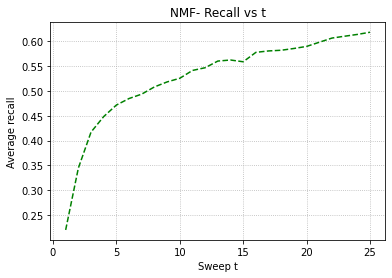

In [ ]:
plt.plot(t,rec_list_NMF,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('NMF- Recall vs t')
plt.ylabel('Average recall')
plt.xlabel('Sweep t')
plt.savefig('Q14b2.png',dpi=350,bbox_inches='tight')
plt.show()

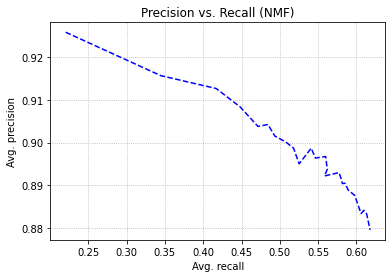

In [ ]:
plt.plot(rec_list_NMF,prec_list_NMF,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Precision vs. Recall (NMF)')
plt.ylabel('Avg. precision')
plt.xlabel('Avg. recall')
plt.savefig('Q14b3.png',dpi=350,bbox_inches='tight')
plt.show()

In [ ]:
#High Variance
t = np.arange(1,26,1)
k_fold = KFold(n_splits=10)

In [ ]:
prec_list_SVD = []
rec_list_SVD = []
for val in t:
    print('Iteration for the value of t =',val)
    precision_Local_set = []
    recall_Local_set = []
    for Train_list, Test_list in k_fold.split(Dataset_Ratings):
        D = {} 
        for row in Test_list:
            if row[0] in D.keys():
                if row[2] >= 3.0:
                    D[row[0]].add(row[1])
            else:
                D[row[0]] = set()
                if row[2] >= 3.0:
                    D[row[0]].add(row[1])    
        dict_of_items = {} 
        for row in Test_list:
            if row[0] in dict_of_items.keys():
                dict_of_items[row[0]].append(row[1])
            else:
                dict_of_items[row[0]] = []
                dict_of_items[row[0]].append(row[1])
        SVD_mod_testset = [row for row in Test_list if (len(dict_of_items[row[0]]) >= val and len(D[row[0]]) > 0)]
        res = SVD(n_factors=20,n_epochs=20,verbose=False).fit(Train_list).test(SVD_mod_testset)
        Est_Ratings = {} 
        for row in res:
            if row[0] in Est_Ratings.keys():
                Est_Ratings[row[0]].append((row[1],row[3]))
            else:
                Est_Ratings[row[0]] = []
                Est_Ratings[row[0]].append((row[1],row[3]))
        precision_u = []
        recall_u = []
        for item in Est_Ratings.keys():
            Set_all = Est_Ratings[item]
            Set_all = sorted(Set_all,key=lambda x:x[1],reverse=True)
            Set_t = set([row[0] for row in Set_all[0:val]])
            precision_u.append(len(Set_t.intersection(D[item]))/float(len(Set_t)))
            recall_u.append(len(Set_t.intersection(D[item]))/float(len(D[item])))
        precision_Local_set.append(np.mean(precision_u))
        recall_Local_set.append(np.mean(recall_u))
    prec_list_SVD.append(np.mean(precision_Local_set))
    rec_list_SVD.append(np.mean(recall_Local_set))

Iteration for the value of t = 1
Iteration for the value of t = 2
Iteration for the value of t = 3
Iteration for the value of t = 4
Iteration for the value of t = 5
Iteration for the value of t = 6
Iteration for the value of t = 7
Iteration for the value of t = 8
Iteration for the value of t = 9
Iteration for the value of t = 10
Iteration for the value of t = 11
Iteration for the value of t = 12
Iteration for the value of t = 13
Iteration for the value of t = 14
Iteration for the value of t = 15
Iteration for the value of t = 16
Iteration for the value of t = 17
Iteration for the value of t = 18
Iteration for the value of t = 19
Iteration for the value of t = 20
Iteration for the value of t = 21
Iteration for the value of t = 22
Iteration for the value of t = 23
Iteration for the value of t = 24
Iteration for the value of t = 25


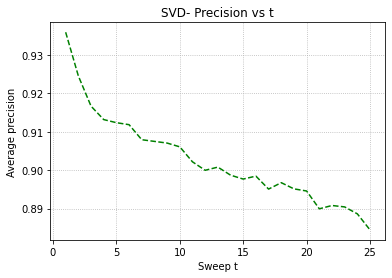

In [ ]:
plt.plot(t,prec_list_SVD,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('SVD- Precision vs t')
plt.ylabel('Average precision')
plt.xlabel('Sweep t')
plt.savefig('Q14c1.png',dpi=350,bbox_inches='tight')
plt.show()

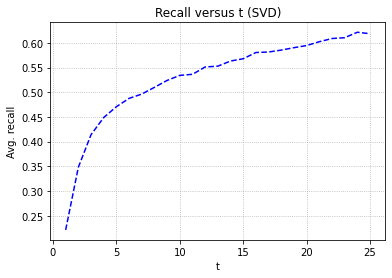

In [ ]:
plt.plot(t,rec_list_SVD,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Recall versus t (SVD)')
plt.ylabel('Avg. recall')
plt.xlabel('t')
plt.savefig('Q14c2.png',dpi=350,bbox_inches='tight')
plt.show()


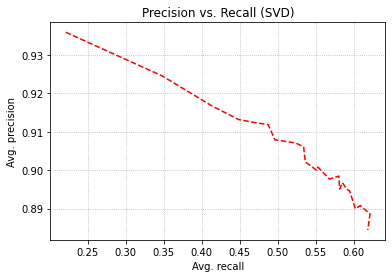

In [ ]:
plt.plot(rec_list_SVD,prec_list_SVD,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Precision vs. Recall (SVD)')
plt.ylabel('Avg. precision')
plt.xlabel('Avg. recall')
plt.savefig('Q14c3.png',dpi=300,bbox_inches='tight')
plt.show()

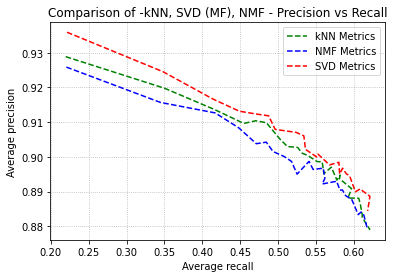

In [ ]:
fig, ax = plt.subplots()
ax.plot(rec_list_KNN,prec_list_KNN,linestyle='--',color='g',label='kNN Metrics')
ax.plot(rec_list_NMF,prec_list_NMF,linestyle='--',color='b',label='NMF Metrics')
ax.plot(rec_list_SVD,prec_list_SVD,linestyle='--',color='r',label='SVD Metrics')
plt.grid(linestyle=':')
plt.title('Comparison of -kNN, SVD (MF), NMF - Precision vs Recall')
plt.ylabel('Average precision')
plt.xlabel('Average recall')
plt.legend(loc="best")
plt.savefig('Q14d.png',dpi=350,bbox_inches='tight')
plt.show()